In [1]:
from rl import *
from recsim.agents import  full_slate_q_agent
from irl_agent import InverseRLAgent
import tensorflow.compat.v1 as tf
import time
from numpy import load
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define reward functions

def v1_clicked_evaluation_reward(responses):
    reward = 0.0
    for response in responses:
        if response.clicked:
            if response.evaluated:
                reward += 1
    return reward

def v2_clicked_evaluation_reward(responses):
    reward = 0.0
    for response in responses:
        if response.clicked:
            if response.evaluated:
                reward += int((response.accuracy_eval + response.importance_eval
                                   + response.pedagogy_eval + response.entertainment_eval) / 4)
    return reward

def clicked_engagement_reward(responses):
    reward = 0.0
    for response in responses:
        if response.clicked:
            reward += response.watch_time
    return reward

# useful plotting function for result visualisation

def plot_chart1(x_,y_,c, x_label, y_label):
    plt.plot(x_, y_, c)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_chart2(x_,y_, x_label, y_label):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.stem(x_, y_)
    plt.show()
    
def plot_3a(t,data1,data2,axe1,axe2,ro1="ro",bo2="bo",x_="episodes"):
    # Create some mock data
    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(x_)
    ax1.set_ylabel(axe1, color=color)
    ax1.plot(t, data1, ro1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(axe2, color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, bo2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Evaluation of the AL/IRL model

In this section, we evaluate the performance of the expert policy generated by AL/IRL component, which saved for our simulation
in policyV1.npy. We also use its associated states dataset stored in file statesV1.npy .

In [3]:
max_episode = 500
slate_size = 2
num_candidates = 5

env_config = {
        'num_candidates': num_candidates,
        'slate_size': slate_size,
        'resample_documents': True,
        'seed': 0,
        'reward_function':clicked_engagement_reward
    }

# User simulation environment: interest evolution model presented in the paper of SlateQ
recsim_gym_env = interest_evolution.create_environment(env_config)

# Load the learned policy from the Expert IRL model as well as the resulted/associated states
states = load('../datasets_states/statesV1.npy', allow_pickle=True)
policy_ = load('../datasets_states/policyV1.npy', allow_pickle=True)

# Instanciate the Expert IRL agent 
agent_irl = InverseRLAgent(recsim_gym_env, states, policy_, num_cand=num_candidates,
                               slate_size=slate_size, max_steps_per_episode=100, ml_model=False)



In [4]:
results = []
# generate independent episodes
for i in range(max_episode):
    steps, reward, time_, found, exp_watch, user_metrics = agent_irl.run_one_episode()
    results += [[i,steps, reward, time_, found, exp_watch, user_metrics]]
    print("episode",i)

episode 0
episode 1
episode 2
episode 3
episode 4
episode 5
episode 6
episode 7
episode 8
episode 9
episode 10
episode 11
episode 12
episode 13
episode 14
episode 15
episode 16
episode 17
episode 18
episode 19
episode 20
episode 21
episode 22
episode 23
episode 24
episode 25
episode 26
episode 27
episode 28
episode 29
episode 30
episode 31
episode 32
episode 33
episode 34
episode 35
episode 36
episode 37
episode 38
episode 39
episode 40
episode 41
episode 42
episode 43
episode 44
episode 45
episode 46
episode 47
episode 48
episode 49
episode 50
episode 51
episode 52
episode 53
episode 54
episode 55
episode 56
episode 57
episode 58
episode 59
episode 60
episode 61
episode 62
episode 63
episode 64
episode 65
episode 66
episode 67
episode 68
episode 69
episode 70
episode 71
episode 72
episode 73
episode 74
episode 75
episode 76
episode 77
episode 78
episode 79
episode 80
episode 81
episode 82
episode 83
episode 84
episode 85
episode 86
episode 87
episode 88
episode 89
episode 90
episode 9

In [6]:
episodes = np.linspace(0,max_episode-1, max_episode)
user_reward = []
expert_reward = []
episode_steps = []
episode_found_state = []
episode_clicked = []
episode_videos_length = []
episode_total_quality = []
episode_expert_quality = []

for i in range(len(results)):
    episode_steps += [results[i][1]]
    user_reward += [results[i][2]]
    episode_found_state += [results[i][4]]
    expert_reward += [results[i][5]]
    episode_clicked += [results[i][6][0]]
    episode_videos_length += [results[i][6][1]]
    episode_expert_quality += [results[i][6][2]]
    episode_total_quality += [results[i][6][3]]
    
ratio_watch = [user_reward[i] for i in range(len(episode_videos_length))]

In [24]:
from numpy import save
a = results
save('../results.npy', a)

The table below shows the following simulation metrics:
<ul>
    <li>#episode_steps: length of the episode ( number of states) </li> 
    <li>#episode_match_state: number of user states that have been matched by
        the classification algorithm to similar expert states </li>
    <li>T_clicked videos: Total number of videos that have been clicked by users within the episode (session) </li>
    <li>T_episode_quality: total quality calculated for the episode </li>
    <li>expert_deleg_quality: quality calculated for watched videos that belongs to states of #episode_match_state</li>
    <li>T_videos_length: duration of all videos watched in a given episode </li>
    <li>T_watching_time: Total watching time of clicked videos</li>
    
</ul>
<strong>Note 1</strong>: In some episodes, T_watching_time values are greater than T_videos_length while it is supposed to be the contrary. However, this situation may happen because of some videos that are watched more than one time.<br/>
<strong>Note 2</strong>: Metrics T_episode_quality and expert_deleg_quality gives an indea about how much it is beneficial to follow expert rated videos, which are recommended based on our approach. For instance, in the episode 0, we have 30 videos that have been seen through the expert policy of our approach. These videos are delivering a quality of 0.449174. However, for the rest 32 videos (62-30=32), which are watched by a random recommendation because their states are not matched to any expert state from the states dataset, they then led to dicrease the quality (by negative quality values) ending up by a total quality of  0.32 .

In [7]:
import pandas as pd
data = np.array([episode_steps, episode_found_state,  episode_clicked, 
            episode_total_quality, episode_expert_quality, episode_videos_length, user_reward, ratio_watch])
pd.DataFrame(data, columns=np.arange(max_episode), index=["#episode_steps", "#episode_match_state",  "T_clicked videos",
                             "T_episode_quality", "expert_deleg_quality", "T_videos_length", "T_watching_time"," ratio_watching"])

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
#episode_steps,72,80,71,71,63,66,71,71,68,72,...,70,69,70,74,63,84,77,72,65,67
#episode_match_state,34,38,39,25,36,34,42,27,24,35,...,36,38,24,25,41,27,27,22,40,41
T_clicked videos,45,41,43,42,41,43,43,40,40,40,...,39,43,41,38,41,37,39,38,44,43
T_episode_quality,0.407209,0.613405,0.380639,0.109072,0.2812,0.309445,0.403112,0.173908,0.21082,0.430466,...,0.481182,0.423516,0.13251,0.148827,0.374591,0.327168,0.423721,0.0606199,0.270852,0.446711
expert_deleg_quality,0.46223,0.646659,0.379925,0.38058,0.384096,0.44742,0.430944,0.355121,0.322698,0.459345,...,0.524856,0.509149,0.267428,0.465868,0.374591,0.520743,0.427855,0.315018,0.336749,0.442749
T_videos_length,197.104,179.838,188.82,178.054,167.617,180.832,183.315,176.371,169.177,177.348,...,169.288,182.034,174.311,165.767,181.656,152.674,164.412,167.571,193.758,193.693
T_watching_time,[173.3279418708072],[158.59794017080176],[172.91773163109693],[169.53822462774676],[173.26864763987805],178.704,[169.81611845997233],[166.54712544261537],[170.05512173774804],[164.82095424640352],...,[165.91896933004838],[173.25441682360818],172.029,[161.78881050456766],[176.8188470671441],[150.54344178391858],[161.01152265349407],[164.13892133934564],[174.95473332798957],[174.99006138260188]
ratio_watching,[173.3279418708072],[158.59794017080176],[172.91773163109693],[169.53822462774676],[173.26864763987805],178.704,[169.81611845997233],[166.54712544261537],[170.05512173774804],[164.82095424640352],...,[165.91896933004838],[173.25441682360818],172.029,[161.78881050456766],[176.8188470671441],[150.54344178391858],[161.01152265349407],[164.13892133934564],[174.95473332798957],[174.99006138260188]


Figure 1 below shows that the delegated expert quality values positively increase the total quality as explained in note 2 of cell 7.


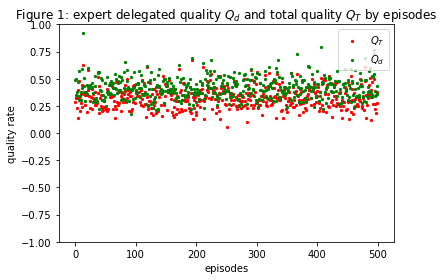

In [28]:
#plt.plot(episodes, ratio_watch, color='blue', label = "watching_time", marker='o')
plt.scatter(episodes, episode_total_quality, color='red',  s=5, label = "$Q_T$", marker='o')
plt.scatter(episodes, episode_expert_quality, color='green', s=5, label = "$Q_d$", marker='o')
plt.ylim(-1, 1)
#plt.xticks(np.arange(min(episodes), max(episodes)+1, 1.0))
plt.xlabel("episodes")
plt.ylabel("quality rate")
plt.legend(loc='upper right')
plt.title("Figure 1: expert delegated quality $Q_d$ and total quality $Q_T$ by episodes")
plt.savefig("q_eval.png", bbox_inches='tight')
plt.show()

## Comparison of our approach recFEBR  with the baseline methodes: recFSQ and recNaive

### Training ...

In [8]:
from recsim.agents import  full_slate_q_agent, random_agent
from irl_agent import InverseRLAgent
import tensorflow.compat.v1 as tf
import time
from numpy import load


def run_one_episode(env, agent, max_steps_per_episode=100):
    observation = env.reset()
    action = agent.begin_episode(observation)
    step_number = 0
    total_watch = 0.
    q_videos = []
    w_videos = []
    total_qual = 0
    start_time = time.time()
    total_length_videos = 0
    while True:
        observation, reward, done, info, _ = env.step(action)

        for j in range(len(observation['response'])):
            if observation['response'][j]['click'] == 1:
                index = action[j]
                total_length_videos += list(observation['doc'].values())[index][-1]
                total_watch += reward[1]
                total_qual += reward[0]
                q_videos += [reward[0]]
                w_videos += [reward[1]]

        # Update environment-specific metrics with responses to the slate.
        env.update_metrics(observation['response'], info)
        step_number += 1

        if done:
            break
        elif step_number == max_steps_per_episode:
            # Stop the run loop once we reach the true end of episode.
            break
        else:
            action = agent.step(reward[1], observation)

    agent.end_episode(reward[1], observation)
    time_diff = time.time() - start_time

    return step_number, total_watch, time_diff, total_qual/step_number, q_videos, w_videos
def clicked_quality_reward(responses):
    """Calculates the total clicked watchtime from a list of responses.

    Args:
      responses: A list of IEvResponse objects

    Returns:
      reward: A float representing the total watch time from the responses
    """
    qual = 0.0
    watch = 0.0
    for response in responses:
        if response.clicked:
            qual += float(response.quality)
            watch += float(response.watch_time)
    return [qual, watch]



def create_agent_random(slate_size, random_seed=0):
    action_space = spaces.MultiDiscrete(num_candidates * np.ones((slate_size,)))
    return random_agent.RandomAgent(action_space, random_seed)


### recNaive simulation

In [9]:
slate_size = 2
num_candidates = 5
env_config1 = {
        'num_candidates': num_candidates,
        'slate_size': slate_size,
        'resample_documents': True,
        'seed': 0,
        'reward_function':clicked_quality_reward
    }

recsim_gym_env = interest_evolution.create_environment(env_config1)
agent = create_agent_random(slate_size)
results_r = []
for i in range(max_episode):
    steps_r, watch, time_r, q, q_vid, w_vid = run_one_episode(recsim_gym_env, agent)
    results_r += [[i,steps_r, watch, time_r, q, q_vid, w_vid ]]
    print("episode ", i)

    
episode_steps_r = []
episode_ratio_watch_r = []
episode_total_quality_r = []
episodes_qv = []
episodes_wv = []

for i in range(len(results_r)):
    episode_steps_r += [results_r[i][1]]
    episode_ratio_watch_r += [results_r[i][2]]
    episode_total_quality_r += [results_r[i][4]]
    episodes_qv += [results_r[i][5]]
    episodes_wv += [results_r[i][6]]
    


episode  0
episode  1
episode  2
episode  3
episode  4
episode  5
episode  6
episode  7
episode  8
episode  9
episode  10
episode  11
episode  12
episode  13
episode  14
episode  15
episode  16
episode  17
episode  18
episode  19
episode  20
episode  21
episode  22
episode  23
episode  24
episode  25
episode  26
episode  27
episode  28
episode  29
episode  30
episode  31
episode  32
episode  33
episode  34
episode  35
episode  36
episode  37
episode  38
episode  39
episode  40
episode  41
episode  42
episode  43
episode  44
episode  45
episode  46
episode  47
episode  48
episode  49
episode  50
episode  51
episode  52
episode  53
episode  54
episode  55
episode  56
episode  57
episode  58
episode  59
episode  60
episode  61
episode  62
episode  63
episode  64
episode  65
episode  66
episode  67
episode  68
episode  69
episode  70
episode  71
episode  72
episode  73
episode  74
episode  75
episode  76
episode  77
episode  78
episode  79
episode  80
episode  81
episode  82
episode  83
ep

### recFSQ simulation

In [10]:
slate_size = 2
num_candidates = 5
env_config1 = {
        'num_candidates': num_candidates,
        'slate_size': slate_size,
        'resample_documents': True,
        'seed': 0,
        'reward_function':clicked_quality_reward
    }

recsim_gym_env = interest_evolution.create_environment(env_config1)
results_f = []

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    
    agent = full_slate_q_agent.FullSlateQAgent(sess, recsim_gym_env.observation_space, recsim_gym_env.action_space)
    for i in range(max_episode):
        steps_f, watch, time_f, q, q_vid, w_vid = run_one_episode(recsim_gym_env, agent)
        results_f += [[i, steps_f, watch, time_f, q, q_vid, w_vid]]
        print("episode ", i)
        sess.run(tf.global_variables_initializer())

    
episode_steps_f = []
episode_ratio_watch_f = []
episode_total_quality_f = []
episodes_qvf = []
episodes_wvf = []


for i in range(len(results_f)):
    episode_steps_f += [results_f[i][1]]
    episode_ratio_watch_f += [results_f[i][2]]
    episode_total_quality_f += [results_f[i][4]]
    episodes_qvf += [results_f[i][5]]
    episodes_wvf += [results_f[i][6]]

INFO:tensorflow:Creating FullSlateQAgent agent with the following parameters:


C:\Users\Moham\PycharmProjects\ExpertDrivenRec\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
INFO:tensorflow:Creating FullSlateQAgent agent with the following parameters:


INFO:tensorflow:	 gamma: 0.990000


INFO:tensorflow:	 gamma: 0.990000


INFO:tensorflow:	 update_horizon: 1.000000


INFO:tensorflow:	 update_horizon: 1.000000


INFO:tensorflow:	 min_replay_history: 20000


INFO:tensorflow:	 min_replay_history: 20000


INFO:tensorflow:	 update_period: 4


INFO:tensorflow:	 update_period: 4


INFO:tensorflow:	 target_update_period: 8000


INFO:tensorflow:	 target_update_period: 8000


INFO:tensorflow:	 epsilon_train: 0.010000


INFO:tensorflow:	 epsilon_train: 0.010000


INFO:tensorflow:	 epsilon_eval: 0.001000


INFO:tensorflow:	 epsilon_eval: 0.001000


INFO:tensorflow:	 epsilon_decay_period: 250000


INFO:tensorflow:	 epsilon_decay_period: 250000


INFO:tensorflow:	 tf_device: /cpu:*


INFO:tensorflow:	 tf_device: /cpu:*


INFO:tensorflow:	 use_staging: True


INFO:tensorflow:	 use_staging: True


INFO:tensorflow:	 optimizer: <tensorflow.python.training.rmsprop.RMSPropOptimizer object at 0x0000017A2E8F9BE0>


INFO:tensorflow:	 optimizer: <tensorflow.python.training.rmsprop.RMSPropOptimizer object at 0x0000017A2E8F9BE0>


INFO:tensorflow:	 max_tf_checkpoints_to_keep: 4


INFO:tensorflow:	 max_tf_checkpoints_to_keep: 4


INFO:tensorflow:Creating a OutOfGraphReplayBuffer replay memory with the following parameters:


INFO:tensorflow:Creating a OutOfGraphReplayBuffer replay memory with the following parameters:


INFO:tensorflow:	 observation_shape: (6, 5)


INFO:tensorflow:	 observation_shape: (6, 5)


INFO:tensorflow:	 observation_dtype: float32


INFO:tensorflow:	 observation_dtype: float32


INFO:tensorflow:	 terminal_dtype: <class 'numpy.uint8'>


INFO:tensorflow:	 terminal_dtype: <class 'numpy.uint8'>


INFO:tensorflow:	 stack_size: 1


INFO:tensorflow:	 stack_size: 1


INFO:tensorflow:	 replay_capacity: 1000000


INFO:tensorflow:	 replay_capacity: 1000000


INFO:tensorflow:	 batch_size: 32


INFO:tensorflow:	 batch_size: 32


INFO:tensorflow:	 update_horizon: 1


INFO:tensorflow:	 update_horizon: 1


INFO:tensorflow:	 gamma: 0.990000


INFO:tensorflow:	 gamma: 0.990000


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Please use tf.global_variables instead.


INFO:tensorflow:legacy_checkpoint_load: False


INFO:tensorflow:legacy_checkpoint_load: False


episode  0
episode  1
episode  2
episode  3
episode  4
episode  5
episode  6
episode  7
episode  8
episode  9
episode  10
episode  11
episode  12
episode  13
episode  14
episode  15
episode  16
episode  17
episode  18
episode  19
episode  20
episode  21
episode  22
episode  23
episode  24
episode  25
episode  26
episode  27
episode  28
episode  29
episode  30
episode  31
episode  32
episode  33
episode  34
episode  35
episode  36
episode  37
episode  38
episode  39
episode  40
episode  41
episode  42
episode  43
episode  44
episode  45
episode  46
episode  47
episode  48
episode  49
episode  50
episode  51
episode  52
episode  53
episode  54
episode  55
episode  56
episode  57
episode  58
episode  59
episode  60
episode  61
episode  62
episode  63
episode  64
episode  65
episode  66
episode  67
episode  68
episode  69
episode  70
episode  71
episode  72
episode  73
episode  74
episode  75
episode  76
episode  77
episode  78
episode  79
episode  80
episode  81
episode  82
episode  83
ep

### Statistics and comparison

C:\Program Files\Python\Python37\Lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


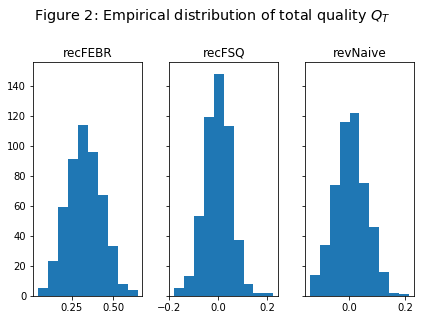

In [49]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 10

# Generate a normal distribution, center at x=0 and y=5

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(episode_total_quality, bins=n_bins)
axs[0].set_title("recFEBR")
axs[1].hist(episode_total_quality_f, bins=n_bins)
axs[1].set_title("recFSQ")
axs[2].hist(episode_total_quality_r, bins=n_bins)
axs[2].set_title("revNaive")
st=fig.suptitle("Figure 2: Empirical distribution of total quality $Q_T$", fontsize="x-large")
st.set_y(1.1)

In [95]:
import pandas as pd
data_quality = [sum(episode_total_quality_f) / max_episode, sum(episode_total_quality_r) / max_episode, sum(episode_total_quality) / max_episode]
data_watch_time = [sum(episode_ratio_watch_f), sum(episode_ratio_watch_r), float(sum(user_reward))]
data = np.array([data_quality, data_watch_time])
pd.DataFrame(data, columns=["recFSQ", "recNaive", "recFEBR"], index=["Average total quality $Q_T$","Total watching time $W_T$"])

,recFSQ,recNaive,recFEBR
Average total quality $Q_T$,-0.001319,0.004825,0.326880
Total watching time $W_T$,85507.750344,85076.328869,85378.299611


In [99]:
df_quality = pd.DataFrame([episode_total_quality, episode_total_quality_f, episode_total_quality_r], index=["FEBR","Full_Q","Naive_random_"])
data1 = df_quality.T
data1.describe()

,FEBR,Full_Q,Naive_random_
count,500.000000,500.000000,500.000000
mean,0.326880,-0.001319,0.004825
std,0.102646,0.055119,0.056879
min,0.046053,-0.179261,-0.141012
25%,0.255537,-0.037877,-0.033508
50%,0.329900,-0.002137,0.004459
75%,0.398835,0.034890,0.042109
max,0.646685,0.225735,0.213905


Text(0.5, 1.0, 'Figure 3: Comparison of the total watch time $W_T$ (seconds)')

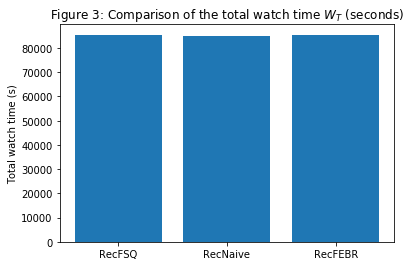

In [100]:
name_file = "w_t_compar.png"
approaches = ["RecFSQ","RecNaive", "RecFEBR"]
plt.bar(approaches, data[1])
plt.ylabel('Total watch time (s)')
plt.title("Figure 3: Comparison of the total watch time $W_T$ (seconds)")
# saving file into result folder
#plt.savefig("../eval_results/"+name_file,, bbox_inches='tight')

Text(0.5, 1.0, 'Figure 4: Comparison of the average total quality $Q_T$ ')

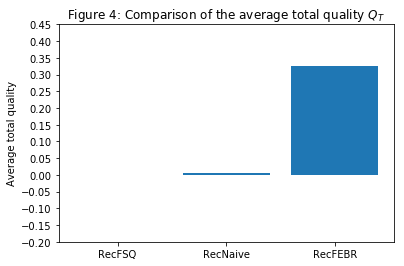

In [101]:
name_file = "q_t_compar.png"
plt.bar(approaches, data[0])
plt.ylabel('Average total quality')
plt.yticks(np.arange(-0.2, 0.5, 0.05))
plt.title("Figure 4: Comparison of the average total quality $Q_T$ ")
# saving file into result folder
#plt.savefig("../eval_results/"+name_file, bbox_inches='tight')
